functions to make:
- position pdf {x}
- order param pdf {}
- stats on pdfs {}
- wall residence time {}
- bounce angle {}
- collision waiting time {}
- elastic mode amplitudes {}
- KE, PE {x}
- PCA, DMD {}
- MSE {}

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec


/Users/alexleffell/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/alexleffell/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [31]:
# Function Defs
# Plot FFT
def plot_fft(time_series, sampling_rate=30, threshold=.8):
    """
    Plot the FFT of a time series.
    
    Parameters:
    time_series: array-like, input signal
    sampling_rate: float, samples per unit time
    """
    n = len(time_series)
    
    # Compute FFT and frequencies
    yf = fft(time_series)
    xf = fftfreq(n, 1/sampling_rate)
    
    # Only plot positive frequencies
    pos_freq_mask = xf >= 0
    Y = 2.0/n * np.abs(yf[pos_freq_mask])
    try:
        peak_ind = find_peaks(Y,threshold)[0][0]
        print(xf[pos_freq_mask][peak_ind])
    except:
        print("no peaks")
        
    # Create subplot with time domain and frequency domain
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Time domain plot
    ax1.plot(np.arange(n)/sampling_rate, time_series)
    ax1.set_title('Time Domain')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')
    
    # Frequency domain plot
    ax2.plot(xf[pos_freq_mask], Y)
    ax2.set_title('Frequency Domain')
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Magnitude')
    
    plt.tight_layout()
    plt.show()

# Function to compute FFT for a single variable
def compute_fft(data):
    n = len(data)  # Number of data points
    fft_values = fft(data)  # Compute FFT
    fft_magnitude = np.abs(fft_values[:n // 2])  # Take magnitude of FFT (first half)
    return fft_magnitude

# Main function to compute and plot averaged FFT
def plot_averaged_fft(df):
    # Ensure the first column is time and extract variables
    time = df.iloc[:, 0]
    variables = df.iloc[:, 1:]

    # Sampling frequency (assume uniform spacing)
    dt = np.mean(np.diff(time))
    sampling_freq = 1 / dt

    # Frequency axis
    n = len(time)
    freqs = np.linspace(0, sampling_freq / 2, n // 2)

    # Compute FFT for each variable and store results
    fft_results = []
    for column in variables.columns:
        fft_magnitude = compute_fft(variables[column].values)
        fft_results.append(fft_magnitude)

    # Average FFT magnitudes
    averaged_fft = np.mean(fft_results, axis=0)

    # Plot averaged FFT
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, averaged_fft, label='Averaged FFT')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title('Averaged FFT of Variables')
    plt.grid()
    plt.legend()
    plt.show()
    
    return freqs, averaged_fft

# Bounce angle function defs

def low_pass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter to the data.

    Parameters:
    data (array): Input data to filter
    cutoff (float): Cutoff frequency for the filter
    fs (float): Sampling frequency
    order (int): Order of the Butterworth filter

    Returns:
    array: Filtered data
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)
def detect_collisions(t, x, y, threshold=0.5, cutoff=1.0):
    """
    Detect the time indices of collisions based on peaks in acceleration.

    Parameters:
    t (array): Time array
    x (array): X position array
    y (array): Y position array
    threshold (float): Threshold for peak detection
    cutoff (float): Cutoff frequency for the low-pass filter

    Returns:
    list of tuples: List of collision indices and types ('vertical' or 'horizontal')
    """
    dt = np.mean(np.diff(t))  # Time step
    fs = 1 / dt  # Sampling frequency

    # Calculate velocity components
    vx = np.gradient(x, t)
    vy = np.gradient(y, t)

    # Apply low-pass filter
    vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
    vy_filtered = low_pass_filter(vy, cutoff=cutoff, fs=fs)

    # Compute the change in filtered velocities (acceleration)
    ax = np.gradient(vx_filtered, t)
    ay = np.gradient(vy_filtered, t)

    # Detect peaks in acceleration
    vertical_peaks, _ = find_peaks(np.abs(ax), height=threshold)
    horizontal_peaks, _ = find_peaks(np.abs(ay), height=threshold)

    # Combine and label collisions
    collisions = [(i, 'vertical') for i in vertical_peaks] + [(i, 'horizontal') for i in horizontal_peaks]
    collisions.sort(key=lambda x: x[0])  # Sort by time index

    return collisions
def calculate_collision_angles(t, x, y, collision_index, collision_type, steps=5, cutoff=1.0):
    """
    Calculate the incident and rebound angles of an object at the time of collision.

    Parameters:
    t (array): Time array
    x (array): X position array
    y (array): Y position array
    collision_index (int): Index of the detected collision
    collision_type (str): Type of collision ('vertical' or 'horizontal')
    steps (int): Number of steps before and after the collision to compute velocity
    cutoff (float): Cutoff frequency for the low-pass filter

    Returns:
    tuple: (incident_angle, rebound_angle) in degrees
    """
    dt = np.mean(np.diff(t))  # Time step
    fs = 1 / dt  # Sampling frequency

    # Calculate velocity components
    vx = np.gradient(x, t)
    vy = np.gradient(y, t)

    # Apply low-pass filter
    vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
    vy_filtered = low_pass_filter(vy, cutoff=cutoff, fs=fs)

    # Average velocity over a few steps before and after collision
    before_start = max(collision_index - steps, 0)
    before_end = collision_index
    after_start = collision_index + 1
    after_end = min(collision_index + 1 + steps, len(t))

    vx_before = np.mean(vx_filtered[before_start:before_end])
    vy_before = np.mean(vy_filtered[before_start:before_end])
    vx_after = np.mean(vx_filtered[after_start:after_end])
    vy_after = np.mean(vy_filtered[after_start:after_end])

    # Calculate angles based on collision type
    if collision_type == 'vertical':
        # Angles are relative to the vertical wall (x-direction)
        incident_angle = np.degrees(np.arctan2(vy_before, -vx_before))
        rebound_angle = np.degrees(np.arctan2(vy_after, -vx_after))
    elif collision_type == 'horizontal':
        # Angles are relative to the horizontal wall (y-direction)
        incident_angle = np.degrees(np.arctan2(-vx_before, vy_before))
        rebound_angle = np.degrees(np.arctan2(-vx_after, vy_after))
    else:
        raise ValueError("Invalid collision type. Must be 'vertical' or 'horizontal'.")

    return incident_angle, rebound_angle
def calculate_residence_time(t, x, y, collision_index, collision_type, cutoff=1.0, velocity_threshold=100):
    """
    Calculate the residence time at the wall during a collision.

    Parameters:
    t (array): Time array
    x (array): X position array
    y (array): Y position array
    collision_index (int): Index of the detected collision
    collision_type (str): Type of collision ('vertical' or 'horizontal')
    cutoff (float): Cutoff frequency for the low-pass filter
    velocity_threshold (float): Threshold for determining "zero" velocity

    Returns:
    float: Residence time in seconds
    """
    dt = np.mean(np.diff(t))  # Time step
    fs = 1 / dt  # Sampling frequency

    # Calculate velocity components
    vx = np.gradient(x, t)
    vy = np.gradient(y, t)

    # Apply low-pass filter
    vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
    vy_filtered = low_pass_filter(vy, cutoff=cutoff, fs=fs)

    # Select the velocity component based on collision type
    if collision_type == 'vertical':
        velocity = vx_filtered
    elif collision_type == 'horizontal':
        velocity = vy_filtered
    else:
        raise ValueError("Invalid collision type. Must be 'vertical' or 'horizontal'.")

    # Find the duration for which the velocity is near zero
    start = collision_index
    while start > 0 and np.abs(velocity[start]) < velocity_threshold:
        start -= 1

    end = collision_index
    while end < len(t) - 1 and np.abs(velocity[end]) < velocity_threshold:
        end += 1

    residence_time = t[end] - t[start]
    return residence_time
def read_csv_comments(file):
    # Read the CSV file, skipping comment lines
    metadata = {}
    with open(file, "r") as f:
        lines = f.readlines()
        # Separate comments (metadata) from actual data
        data_lines = []
        for line in lines:
            if line.startswith("#"):
                # Extract metadata from comment lines
                key, value = line[2:].strip().split(":", 1)
                metadata[key] = ast.literal_eval(value.strip())
            else:
                # Collect data lines (non-comment lines)
                data_lines.append(line)

    # Now read the CSV data into a DataFrame from the data lines
    from io import StringIO
    data_str = "".join(data_lines)  # Join the data lines back into a string
    df_read = pd.read_csv(StringIO(data_str))

    # Attach the metadata back to the DataFrame
    df_read.attrs = metadata
    return df_read
def generate_energy_df(df, C, l0=.1, k=1, m=1):
    """
    df: output of generate_dataframe, with attribute 'n_nodes
    C: list of pairwise node connections
    l0: resting length of spring in [m]
    k: spring constant of springs [N/m]
    m: mass of each node
    
    returns:
    energy: a dataframe containing the distance between each connected node over time
            and the kinetic and potential energy at each time step. Assumes linear 
            kinetic energy dominates over angular.
    """
    energy = []
    n_nodes = df.attrs['n_nodes']
    dt = df['time'].iloc[1]-df['time'].iloc[0]
    for t in range(len(df)):
        row = {}
        PE = 0
        KE = 0
        # calculate displacement for each spring. ASSUMING no bending which is wrong!!
        for c in C:
            n0x = df[str(c[0])+'_x'].iloc[t] 
            n0y = df[str(c[0])+'_y'].iloc[t]
            n1x = df[str(c[1])+'_x'].iloc[t] 
            n1y = df[str(c[1])+'_y'].iloc[t]
            dist = np.sqrt( (n0x-n1x)**2 + (n0y-n1y)**2 )
            row[str(c[0])+"-"+str(c[1])] = dist
            PE += 0.5*k*(l0-dist)**2
        row['PE'] = PE
        if t>0:
            for n in range(n_nodes):
                vx = (df[str(n)+'_x'].iloc[t]-df[str(n)+'_x'].iloc[t-1])/dt
                vy = (df[str(n)+'_y'].iloc[t]-df[str(n)+'_y'].iloc[t-1])/dt
                v = np.sqrt(vx**2 + vy**2)
                KE += 0.5*m*v**2
        row['KE'] = KE
        energy.append(row)
    return pd.DataFrame(energy)
def plot_position_pdf(x,y, bins=30, cmap='Blues'):
    """
    Plots a normalized 2D histogram (equivalent to a probability density function).
    
    Parameters:
    - x, y: Data points.
    - bins: Number of bins for the histogram.
    - cmap: Colormap for visualization.
    """
    hist, x_edges, y_edges = np.histogram2d(x, y, bins=bins, density=True)

    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap=cmap, aspect='auto')
    plt.colorbar(label='Probability Density')
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.title('Normalized 2D Histogram (PDF)')
    plt.show()

def calculate_magnetization(df):
    """
    df: output of generate_dataframe, with attribute 'n_nodes
    returns a list of the magnetizationa at each timestep
    """
    mag = []
    n_nodes = df.attrs['n_nodes']
    for t in range(len(df)):
        step = df.iloc[t]
        m = []
        for n in range(n_nodes):
            m.append( np.exp( 1j * step[f'{n}_angle'] ) )
        mag.append(np.absolute(np.mean(m)))
    return mag



## Load robot data

In [7]:
robot = read_csv_comments('/Users/alexleffell/Documents/PhD/tplax/Data/012925/012925_tape2_robot.csv') 
C = [(0,1),(0,2),(0,3),(0,4),(0,5),(0,6),(1,2),(2,3),(3,4),(4,5),(5,6),(6,1)]
df = generate_energy_df(robot, C, k=10)

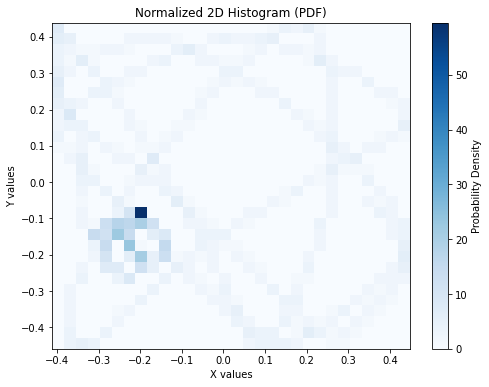

In [8]:
x = robot['centroid_x']
y = robot['centroid_y']
plot_position_pdf(x,y)

In [32]:
m = calculate_magnetization(robot)

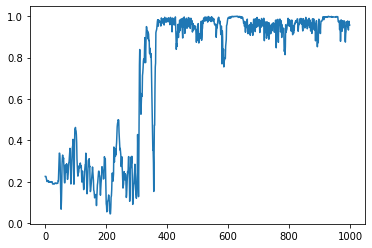

In [33]:
plt.plot(m)

# Try PCA

In [542]:
# PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.signal import spectrogram
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.fft import fft, fftfreq


n = 10
cols = []
for i in range(n):
    cols.append("PC"+str(i+1))

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(robot_df)

# Apply PCA
pca = PCA(n_components=n)
principal_components = pca.fit_transform(scaled_data)
first_component_projected = np.array(pca.inverse_transform(principal_components))

# Create a new DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=cols)

pca.components_[0]



array([-0.27801217, -0.09684936,  0.2096551 , -0.05775667, -0.04396603,
        0.20971627, -0.13469338,  0.06747926,  0.32115403, -0.28032497,
        0.00186025,  0.24096854, -0.05612125, -0.05888194,  0.24300679,
       -0.1336578 ,  0.020529  ,  0.25372432, -0.09317052, -0.04026382,
        0.19617505, -0.09865385,  0.32129498, -0.28295113,  0.01526715,
       -0.15690695, -0.14391648, -0.16173513, -0.1570947 , -0.19367005,
       -0.1832638 ])

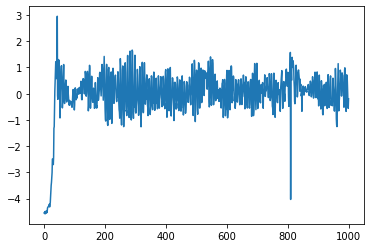

In [543]:
plt.plot(first_component_projected[:,1])

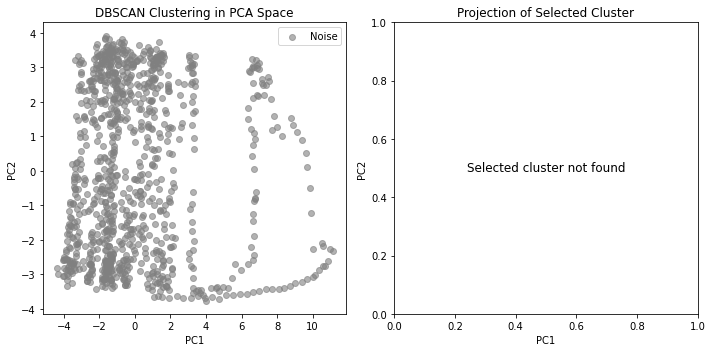

In [544]:
# Cluster the data (e.g., using k-means)
# kmeans = KMeans(n_clusters=3, random_state=2, init='k-means++')
# labels = kmeans.fit_predict(principal_components)

kmeans = DBSCAN(eps=0.6, min_samples=50)
labels = kmeans.fit_predict(principal_components)

# Extract a single cluster
cluster_index = 0  # Replace with the desired cluster index
cluster_mask = labels == cluster_index  # Create a boolean mask

if isinstance(data, pd.DataFrame):
    cluster_data = pca_df.loc[cluster_mask]  # For pandas DataFrame
else:
    cluster_data = pca_df[cluster_mask]      # For NumPy array

# Reproject the original data of the cluster
cluster_pca_projection = principal_components[cluster_mask]  # Extract cluster in PCA space



# Plot DBSCAN clustering
plt.figure(figsize=(10, 5))

# Subplot 1: DBSCAN clustering
plt.subplot(1, 2, 1)
unique_labels = set(labels)
for cluster_index in unique_labels:
    if cluster_index == -1:
        # Noise points
        cluster_points = principal_components[labels == cluster_index]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c='gray', label='Noise', alpha=0.6)
    else:
        cluster_points = principal_components[labels == cluster_index]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_index}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clustering in PCA Space')
plt.legend()

# Subplot 2: Selected cluster projection
plt.subplot(1, 2, 2)
selected_cluster_index = 0  # Change to desired cluster index
if selected_cluster_index in unique_labels and selected_cluster_index != -1:
    cluster_mask = labels == selected_cluster_index
    cluster_pca_projection = principal_components[cluster_mask]
    plt.scatter(cluster_pca_projection[:, 0], cluster_pca_projection[:, 1], c='blue', label=f'Cluster {selected_cluster_index}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'Projection of Selected Cluster {selected_cluster_index}')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'Selected cluster not found', ha='center', va='center', fontsize=12)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Projection of Selected Cluster')

plt.tight_layout()
plt.show()

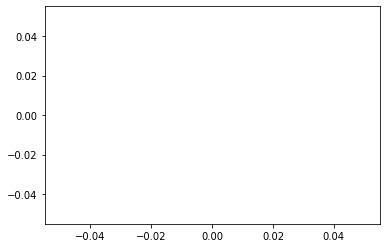

In [545]:
# Plot back-projection of main cluster
cluster_0 = [sum(cluster_pca_projection[i]) for i in range(len(cluster_pca_projection))]
plt.plot(cluster_0)

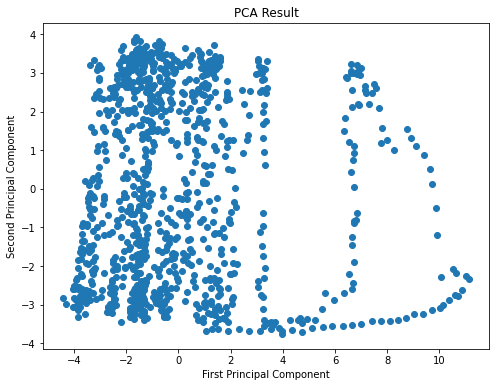

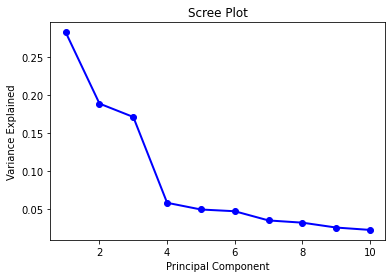

In [546]:
# Scatter plot of first two components and scree plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Result')
plt.show()

# PCA Scree Plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()


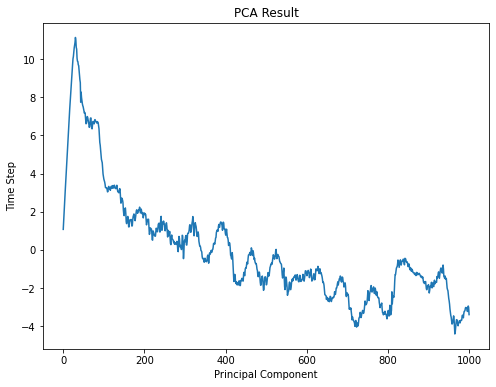

In [547]:
# Plot of first component

plt.figure(figsize=(8, 6))
plt.plot(pca_df['PC1'])
plt.xlabel('Principal Component')
plt.ylabel('Time Step')
plt.title('PCA Result')
plt.show()

0.21


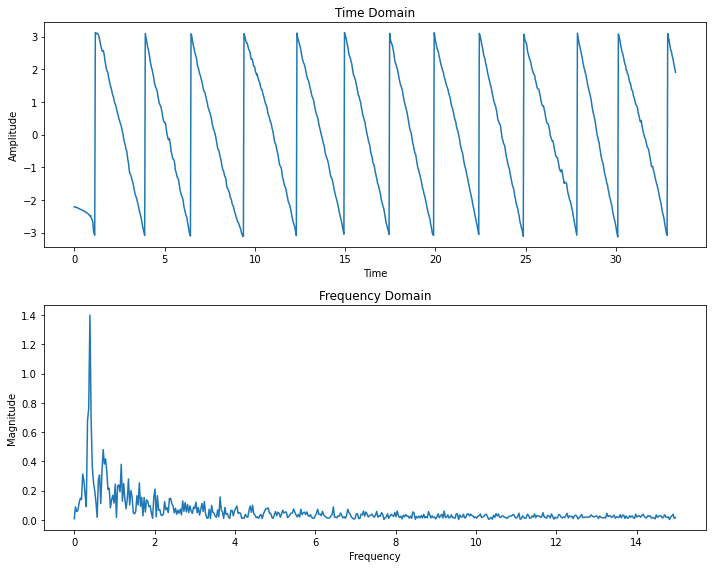

In [567]:
# Plot FFT
def plot_fft(time_series, sampling_rate=1.0, threshold=.8):
    """
    Plot the FFT of a time series.
    
    Parameters:
    time_series: array-like, input signal
    sampling_rate: float, samples per unit time
    """
    n = len(time_series)
    
    # Compute FFT and frequencies
    yf = fft(time_series)
    xf = fftfreq(n, 1/sampling_rate)
    
    # Only plot positive frequencies
    pos_freq_mask = xf >= 0
    Y = 2.0/n * np.abs(yf[pos_freq_mask])
    try:
        peak_ind = find_peaks(Y,threshold)[0][0]
        print(xf[pos_freq_mask][peak_ind])
    except:
        print("no peaks")
        
    # Create subplot with time domain and frequency domain
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Time domain plot
    ax1.plot(np.arange(n)/sampling_rate, time_series)
    ax1.set_title('Time Domain')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')
    
    # Frequency domain plot
    ax2.plot(xf[pos_freq_mask], Y)
    ax2.set_title('Frequency Domain')
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Magnitude')
    
    plt.tight_layout()
    plt.show()

# Function to compute FFT for a single variable
def compute_fft(data):
    n = len(data)  # Number of data points
    fft_values = fft(data)  # Compute FFT
    fft_magnitude = np.abs(fft_values[:n // 2])  # Take magnitude of FFT (first half)
    return fft_magnitude

# Main function to compute and plot averaged FFT
def plot_averaged_fft(df):
    # Ensure the first column is time and extract variables
    time = df.iloc[:, 0]
    variables = df.iloc[:, 1:]

    # Sampling frequency (assume uniform spacing)
    dt = np.mean(np.diff(time))
    sampling_freq = 1 / dt

    # Frequency axis
    n = len(time)
    freqs = np.linspace(0, sampling_freq / 2, n // 2)

    # Compute FFT for each variable and store results
    fft_results = []
    for column in variables.columns:
        fft_magnitude = compute_fft(variables[column].values)
        fft_results.append(fft_magnitude)

    # Average FFT magnitudes
    averaged_fft = np.mean(fft_results, axis=0)

    # Plot averaged FFT
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, averaged_fft, label='Averaged FFT')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title('Averaged FFT of Variables')
    plt.grid()
    plt.legend()
    plt.show()
    
    return freqs, averaged_fft



# spec_data= first_component_projected[:,4] # np.array(cluster_0)
# spec_data = np.array(pca_df["PC1"])
# spec_data = np.array(robot_df["5_angle"])
plot_fft(np.array(robot_df["body_angle"]), sampling_rate=fr, threshold=.31)

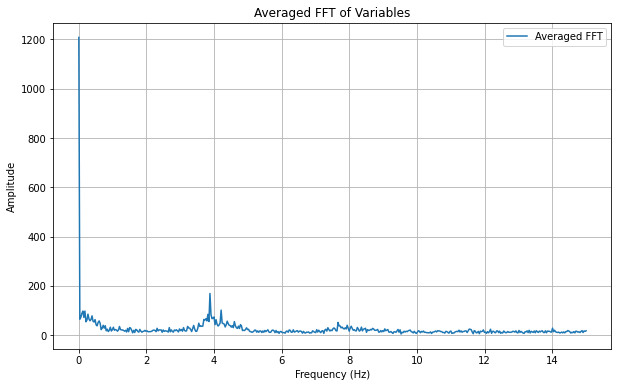

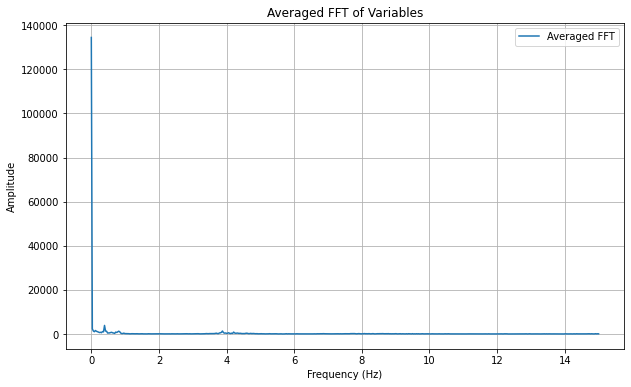

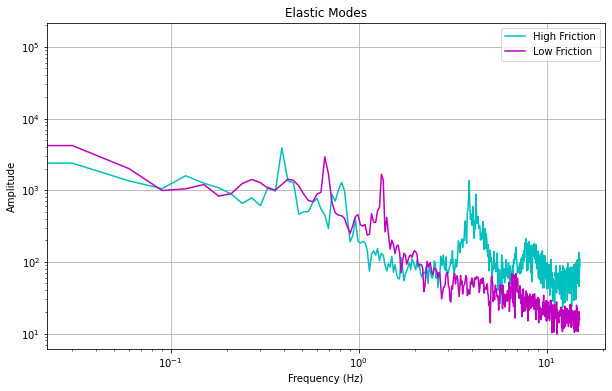

In [554]:
# Plot averaged FFT
dist_df = pd.DataFrame()
dist_df["timestamp"] = robot_df["timestamp"]
for i in range(1,len(node_list)):
    name = str(i)+"_dist"
    dist_df[name] = robot_df[name]

angle_df = pd.DataFrame()
angle_df["timestamp"] = robot_df["timestamp"]
for i in range(1,len(node_list)):
    name = str(i)+"_angle"
    angle_df[name] = robot_df[name]


# rub_angles_freqs, rub_angles_fft = plot_averaged_fft(angle_df)
# rub_dist_freqs, rub_dist_fft = plot_averaged_fft(dist_df)

plt.figure(figsize=(10, 6))
plt.loglog(rub_dist_freqs, rub_dist_fft, label='High Friction', color = 'c')
plt.loglog(plas_dist_freqs, plas_dist_fft, label='Low Friction', color = 'm')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
# plt.ylim(0,1000)
plt.title("Elastic Modes")
plt.grid()
plt.legend()
# plt.savefig('elastic_modes.png')
plt.show()

In [513]:
angles_df

,timestamp
0,0.000000
1,0.033333
2,0.066667
3,0.100000
4,0.133333
...,...
995,33.166667
996,33.200000
997,33.233333
998,33.266667


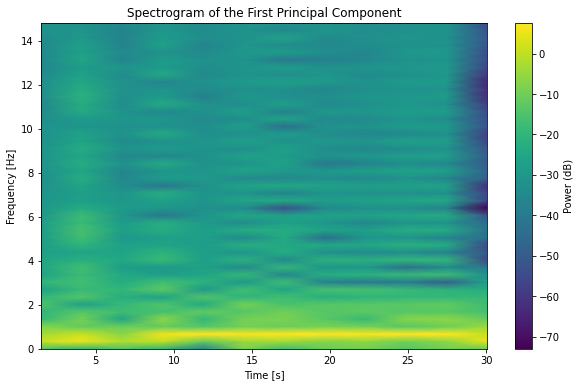

In [396]:
# Spectrogram of component
nperseg = 89  # Length of each segment
noverlap = 4  # Overlap between segments (50% overlap)

# Compute the spectrogram
spec_data = first_component_projected[:,1] # np.array(cluster_0)
# frequencies, times, Sxx = spectrogram(pca_df['PC1'], fs=fr, nperseg=nperseg)  # Adjust `fs` to your sampling frequency
frequencies, times, Sxx = spectrogram(pca_df["PC5"], fs=fr, nperseg=nperseg)  # Adjust `fs` to your sampling frequency

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.title("Spectrogram of the First Principal Component")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.colorbar(label="Power (dB)")
plt.savefig('PC1_Spectrogram.png')
plt.show()

# Get Bounce Angles

In [245]:
# Bounce angle function defs
from scipy.signal import butter, filtfilt, find_peaks

def low_pass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter to the data.

    Parameters:
    data (array): Input data to filter
    cutoff (float): Cutoff frequency for the filter
    fs (float): Sampling frequency
    order (int): Order of the Butterworth filter

    Returns:
    array: Filtered data
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def detect_collisions(t, x, y, threshold=0.5, cutoff=1.0):
    """
    Detect the time indices of collisions based on peaks in acceleration.

    Parameters:
    t (array): Time array
    x (array): X position array
    y (array): Y position array
    threshold (float): Threshold for peak detection
    cutoff (float): Cutoff frequency for the low-pass filter

    Returns:
    list of tuples: List of collision indices and types ('vertical' or 'horizontal')
    """
    dt = np.mean(np.diff(t))  # Time step
    fs = 1 / dt  # Sampling frequency

    # Calculate velocity components
    vx = np.gradient(x, t)
    vy = np.gradient(y, t)

    # Apply low-pass filter
    vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
    vy_filtered = low_pass_filter(vy, cutoff=cutoff, fs=fs)

    # Compute the change in filtered velocities (acceleration)
    ax = np.gradient(vx_filtered, t)
    ay = np.gradient(vy_filtered, t)

    # Detect peaks in acceleration
    vertical_peaks, _ = find_peaks(np.abs(ax), height=threshold)
    horizontal_peaks, _ = find_peaks(np.abs(ay), height=threshold)

    # Combine and label collisions
    collisions = [(i, 'vertical') for i in vertical_peaks] + [(i, 'horizontal') for i in horizontal_peaks]
    collisions.sort(key=lambda x: x[0])  # Sort by time index

    return collisions
def calculate_collision_angles(t, x, y, collision_index, collision_type, steps=5, cutoff=1.0):
    """
    Calculate the incident and rebound angles of an object at the time of collision.

    Parameters:
    t (array): Time array
    x (array): X position array
    y (array): Y position array
    collision_index (int): Index of the detected collision
    collision_type (str): Type of collision ('vertical' or 'horizontal')
    steps (int): Number of steps before and after the collision to compute velocity
    cutoff (float): Cutoff frequency for the low-pass filter

    Returns:
    tuple: (incident_angle, rebound_angle) in degrees
    """
    dt = np.mean(np.diff(t))  # Time step
    fs = 1 / dt  # Sampling frequency

    # Calculate velocity components
    vx = np.gradient(x, t)
    vy = np.gradient(y, t)

    # Apply low-pass filter
    vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
    vy_filtered = low_pass_filter(vy, cutoff=cutoff, fs=fs)

    # Average velocity over a few steps before and after collision
    before_start = max(collision_index - steps, 0)
    before_end = collision_index
    after_start = collision_index + 1
    after_end = min(collision_index + 1 + steps, len(t))

    vx_before = np.mean(vx_filtered[before_start:before_end])
    vy_before = np.mean(vy_filtered[before_start:before_end])
    vx_after = np.mean(vx_filtered[after_start:after_end])
    vy_after = np.mean(vy_filtered[after_start:after_end])

    # Calculate angles based on collision type
    if collision_type == 'vertical':
        # Angles are relative to the vertical wall (x-direction)
        incident_angle = np.degrees(np.arctan2(vy_before, -vx_before))
        rebound_angle = np.degrees(np.arctan2(vy_after, -vx_after))
    elif collision_type == 'horizontal':
        # Angles are relative to the horizontal wall (y-direction)
        incident_angle = np.degrees(np.arctan2(-vx_before, vy_before))
        rebound_angle = np.degrees(np.arctan2(-vx_after, vy_after))
    else:
        raise ValueError("Invalid collision type. Must be 'vertical' or 'horizontal'.")

    return incident_angle, rebound_angle

# def calculate_collision_angles(t, x, y, collision_index, collision_type, cutoff=1.0):
#     """
#     Calculate the incident and rebound angles of an object at the time of collision.

#     Parameters:
#     t (array): Time array
#     x (array): X position array
#     y (array): Y position array
#     collision_index (int): Index of the detected collision
#     collision_type (str): Type of collision ('vertical' or 'horizontal')
#     cutoff (float): Cutoff frequency for the low-pass filter

#     Returns:
#     tuple: (incident_angle, rebound_angle) in degrees
#     """
#     dt = np.mean(np.diff(t))  # Time step
#     fs = 1 / dt  # Sampling frequency

#     # Calculate velocity components
#     vx = np.gradient(x, t)
#     vy = np.gradient(y, t)

#     # Apply low-pass filter
#     vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
#     vy_filtered = low_pass_filter(vy, cutoff=cutoff, fs=fs)

#     # Velocity vectors before and after collision
#     if collision_type == 'vertical':
#         vx_before, vy_before = vx_filtered[collision_index - 1], vy_filtered[collision_index - 1]
#         vx_after, vy_after = vx_filtered[collision_index + 1], vy_filtered[collision_index + 1]
#         incident_angle = np.degrees(np.arctan2(vy_before, -vx_before))
#         rebound_angle = np.degrees(np.arctan2(vy_after, -vx_after))
#     elif collision_type == 'horizontal':
#         vx_before, vy_before = vx_filtered[collision_index - 1], vy_filtered[collision_index - 1]
#         vx_after, vy_after = vx_filtered[collision_index + 1], vy_filtered[collision_index + 1]
#         incident_angle = np.degrees(np.arctan2(-vx_before, vy_before))
#         rebound_angle = np.degrees(np.arctan2(-vx_after, vy_after))
#     else:
#         raise ValueError("Invalid collision type. Must be 'vertical' or 'horizontal'.")

#     return incident_angle, rebound_angle

def calculate_residence_time(t, x, y, collision_index, collision_type, cutoff=1.0, velocity_threshold=100):
    """
    Calculate the residence time at the wall during a collision.

    Parameters:
    t (array): Time array
    x (array): X position array
    y (array): Y position array
    collision_index (int): Index of the detected collision
    collision_type (str): Type of collision ('vertical' or 'horizontal')
    cutoff (float): Cutoff frequency for the low-pass filter
    velocity_threshold (float): Threshold for determining "zero" velocity

    Returns:
    float: Residence time in seconds
    """
    dt = np.mean(np.diff(t))  # Time step
    fs = 1 / dt  # Sampling frequency

    # Calculate velocity components
    vx = np.gradient(x, t)
    vy = np.gradient(y, t)

    # Apply low-pass filter
    vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
    vy_filtered = low_pass_filter(vy, cutoff=cutoff, fs=fs)

    # Select the velocity component based on collision type
    if collision_type == 'vertical':
        velocity = vx_filtered
    elif collision_type == 'horizontal':
        velocity = vy_filtered
    else:
        raise ValueError("Invalid collision type. Must be 'vertical' or 'horizontal'.")

    # Find the duration for which the velocity is near zero
    start = collision_index
    while start > 0 and np.abs(velocity[start]) < velocity_threshold:
        start -= 1

    end = collision_index
    while end < len(t) - 1 and np.abs(velocity[end]) < velocity_threshold:
        end += 1

    residence_time = t[end] - t[start]
    return residence_time

# # Example usage:
# if __name__ == "__main__":
#     # Example data: object moving and colliding with both walls
#     t = np.linspace(0, 10, 200)  # Time from 0 to 10 seconds
#     x = 5 * np.cos(2 * np.pi * t / 10)  # Circular motion
#     y = 5 * np.sin(2 * np.pi * t / 10)

#     # Introduce sharp changes to simulate collisions
#     x[80:] = x[80:] + 1  # Vertical collision
#     y[140:] = y[140:] - 2  # Horizontal collision

#     # Detect collisions
#     collisions = detect_collisions(t, x, y, threshold=1.0, cutoff=1.0)

#     if collisions:
#         for collision_index, collision_type in collisions:
#             print(f"Collision detected at t = {t[collision_index]:.2f}s (index {collision_index}, type {collision_type})")
#             incident, rebound = calculate_collision_angles(t, x, y, collision_index, collision_type, cutoff=1.0)
#             residence_time = calculate_residence_time(t, x, y, collision_index, collision_type, cutoff=1.0)
#             print(f"  Incident Angle: {incident:.2f}°")
#             print(f"  Rebound Angle: {rebound:.2f}°")
#             print(f"  Residence Time: {residence_time:.2f}s")
#     else:
#         print("No collisions detected.")



In [246]:
# Bend method function defs
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the curvature of a 2D trajectory
def calculate_curvature(x, y):
    dx = np.gradient(x)
    dy = np.gradient(y)
    dx_filt = low_pass_filter(dx, cutoff=cutoff, fs=fs)
    dy_filt = low_pass_filter(dy, cutoff=cutoff, fs=fs)
    ddx = np.gradient(dx_filt)
    ddy = np.gradient(dy_filt)

    # Curvature formula: k = |x'y" - y'x"| / (x'^2 + y'^2)^(3/2)
    numerator = np.abs(dx * ddy - dy * ddx)
    denominator = (dx**2 + dy**2)**1.5
    curvature = numerator / np.maximum(denominator, 1e-10)  # Avoid division by zero
    return curvature

# Function to identify sharp bends and estimate bend angles
def identify_bends(x, y, curvature, threshold):
#     sharp_bends = np.where(curvature > threshold)[0]
    sharp_bends, _  = find_peaks(np.abs(curvature), height=threshold)
    angles = []

    for idx in sharp_bends:
        if idx == 0 or idx == len(x) - 1:
            continue  # Skip endpoints

        # Calculate vectors before and after the point
        vec1 = np.array([x[idx] - x[idx - 1], y[idx] - y[idx - 1]])
        vec2 = np.array([x[idx + 1] - x[idx], y[idx + 1] - y[idx]])

        # Normalize vectors
        vec1 /= np.linalg.norm(vec1)
        vec2 /= np.linalg.norm(vec2)

        # Compute the angle between vectors
        dot_product = np.clip(np.dot(vec1, vec2), -1.0, 1.0)
        angle = np.arccos(dot_product) * (180 / np.pi)  # Convert to degrees
        angles.append((idx, angle))

    return sharp_bends, angles


Collision detected at t = 0.83s (index 25, type horizontal)
  Incident Angle: -126.25°
  Rebound Angle: -12.23°
  Residence Time: 0.433 s
Collision detected at t = 1.13s (index 34, type vertical)
  Incident Angle: -162.80°
  Rebound Angle: 32.72°
  Residence Time: 0.433 s
  # collisions: 2.000


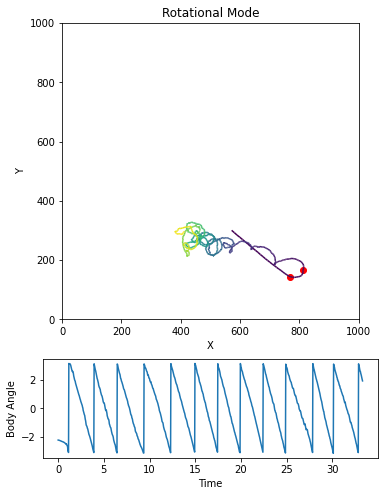

In [287]:
# Detect Bounce Angles
x = robot_df["centroid_x"]
y = robot_df["centroid_y"]
t = robot_df["timestamp"]

vx = np.gradient(x,t)
vy = np.gradient(y,t)
v = np.sqrt(vx**2+vy**2)

# x = min_node["center_x"]
# y = min_node["center_y"]
# t = min_node["timestamp"]/fr

fs = 30
cutoff = 1
steps = 20



collisions = detect_collisions(t, x, y, threshold=500.0, cutoff=1.0)
ratios = []
residence_times = []

if collisions:
    for collision_index, collision_type in collisions:
        print(f"Collision detected at t = {t[collision_index]:.2f}s (index {collision_index}, type {collision_type})")
        incident, rebound = calculate_collision_angles(t, x, y, collision_index, collision_type, cutoff=1.0,steps = steps)
        residence_time = calculate_residence_time(t, x, y, collision_index, collision_type, cutoff=1.0,velocity_threshold=100)
        ratios.append(rebound/incident)
        residence_times.append(residence_time)
        print(f"  Incident Angle: {incident:.2f}°")
        print(f"  Rebound Angle: {rebound:.2f}°")
        print(f"  Residence Time: {residence_time:.3f} s")
    print(f"  # collisions: {len(collisions):.3f}")
else:
    print("No collisions detected.")
    
# Create line segments
time = robot_df["timestamp"]
points = np.array([robot_df["centroid_x"], robot_df["centroid_y"]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a colormap
norm = mcolors.Normalize(vmin=time.min(), vmax=time.max())
cmap = plt.cm.viridis  # Change colormap if desired
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(time)  # Map "time" values to colors

# Plot
# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10))
fig = plt.figure(figsize=(6, 8))  # Overall figure size
gs = GridSpec(2, 1, height_ratios=[3, 1], figure=fig)  # Height ratio: 3:1

ax1 = fig.add_subplot(gs[0])  # First subplot occupies 3/4 of the height
ax1.add_collection(lc)
ax1.set_xlim(0,1000)
ax1.set_ylim(0,1000)
ax1.set_aspect('equal')
#ax1.autoscale()  # Adjust axes limits to fit the line
# plt.colorbar(lc, ax=ax1, label='Time')  # Add a colorbar
ax1.set_title("Rotational Mode")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
for collision_index, collision_type in collisions:
    ax1.scatter(robot_df.iloc[collision_index]["centroid_x"] , robot_df.iloc[collision_index]["centroid_y"], color='r' )


ax2 = fig.add_subplot(gs[1])  # Second subplot occupies 1/4 of the height
ax2.plot(robot_df["timestamp"],robot_df["body_angle"])
ax2.autoscale()  # Adjust axes limits to fit the line
ax2.set_xlabel("Time")
ax2.set_ylabel("Body Angle")
plt.savefig('rot_traj.png')
plt.show()


/var/folders/bb/fz0zm3_96tl62820445bgd5w0000gn/T/ipykernel_46821/3005314055.py:36: RuntimeWarning: invalid value encountered in divide
  vec2 /= np.linalg.norm(vec2)
/var/folders/bb/fz0zm3_96tl62820445bgd5w0000gn/T/ipykernel_46821/3005314055.py:35: RuntimeWarning: invalid value encountered in divide
  vec1 /= np.linalg.norm(vec1)


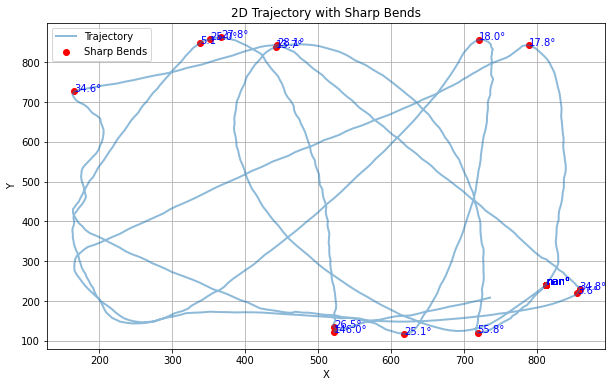

Sharp bends and their angles:
Index: 1, Angle: nan°
Index: 6, Angle: nan°
Index: 9, Angle: nan°
Index: 13, Angle: nan°
Index: 16, Angle: nan°
Index: 19, Angle: nan°
Index: 27, Angle: nan°
Index: 30, Angle: nan°
Index: 32, Angle: nan°
Index: 34, Angle: nan°
Index: 130, Angle: 13.74°
Index: 210, Angle: 55.83°
Index: 291, Angle: 17.83°
Index: 448, Angle: 3.60°
Index: 450, Angle: 34.78°
Index: 522, Angle: 28.14°
Index: 551, Angle: 34.64°
Index: 707, Angle: 18.05°
Index: 780, Angle: 25.13°
Index: 887, Angle: 5.06°
Index: 891, Angle: 24.97°
Index: 895, Angle: 27.77°
Index: 971, Angle: 26.45°
Index: 974, Angle: 145.95°


In [248]:
# Detect Bends
x = robot_df["centroid_x"]
y = robot_df["centroid_y"]
t = robot_df["timestamp"]


# Calculate curvature
curvature = calculate_curvature(x, y)

# Identify sharp bends (adjust threshold as needed)
threshold = 0.02
sharp_bends, angles = identify_bends(x, y, curvature, threshold)

# Plot the trajectory and highlight sharp bends
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Trajectory", lw=2, alpha = 0.5)
plt.scatter(x[sharp_bends], y[sharp_bends], color="red", label="Sharp Bends")

# Annotate bend angles
for idx, angle in angles:
    plt.text(x[idx], y[idx], f"{angle:.1f}°", color="blue", fontsize=10)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Trajectory with Sharp Bends")
plt.legend()
plt.grid()
plt.show()

# Print bend angles
print("Sharp bends and their angles:")
for idx, angle in angles:
    print(f"Index: {idx}, Angle: {angle:.2f}°")


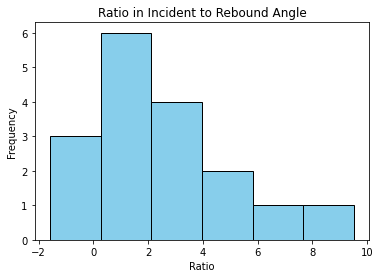

In [185]:
# Create histogram
plt.hist(ratios, bins='auto', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.title('Ratio in Incident to Rebound Angle')
plt.savefig('rebound_hist.png')
# Display the plot
plt.show()


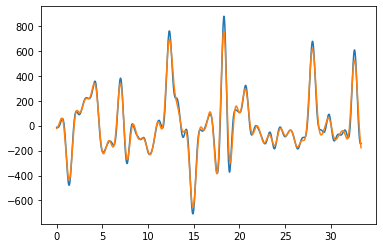

In [95]:
vx = np.gradient(x, t)
vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
ax = np.gradient(vx_filtered,t)
ax_filtered = low_pass_filter(ax, cutoff=cutoff, fs=fs)
n = 1000
plt.plot(t[0:n],ax[0:n],t[0:n],ax_filtered[0:n])

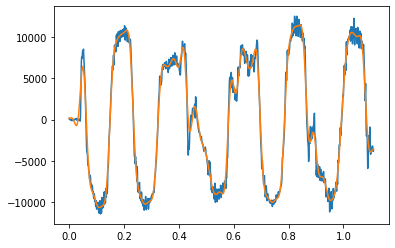

In [74]:
vx = np.gradient(y, t)
vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
n = 1000
plt.plot(t[0:n],vx[0:n],t[0:n],vx_filtered[0:n])

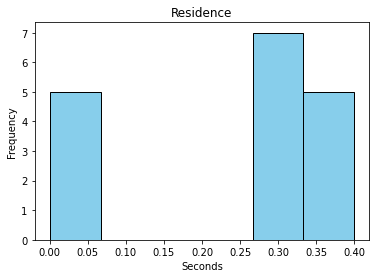

In [186]:
# Create histogram
plt.hist(residence_times, bins='auto', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.title('Residence')
# plt.savefig('rebound_hist.png')
# Display the plot
plt.show()

In [19]:
layered_composite_spring.show()